In [1]:
import pandas as pd
import gcsfs
import numpy as np

# Import and join review/product data

In [2]:
# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

path = f'gs://amazon-home-and-kitchen/full_train_data.csv'
df = pd.read_csv(path)

/var/tmp/ipykernel_10162/3704221986.py:5: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [5]:
list(df.columns)

['main_category',
 'title_x',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'price',
 'images_x',
 'videos',
 'store',
 'categories',
 'details',
 'parent_asin',
 'bought_together',
 'subtitle',
 'author',
 'rating',
 'title_y',
 'text',
 'images_y',
 'asin',
 'user_id',
 'timestamp',
 'helpful_vote',
 'verified_purchase']

In [3]:
# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

items_metadata_file_path = 'gs://amazon-home-and-kitchen/meta_Home_and_Kitchen.jsonl'

# Open the file from the GCS bucket
with fs.open(items_metadata_file_path, 'r') as f:
    # Read the JSONL file in chunks to handle large files efficiently
    #json_reader = pd.read_json(f, lines=True, chunksize=500000)
    
    # Read the JSONL file in 600K rows at a time
    json_reader = pd.read_json(f, lines=True, chunksize=600000)
        
    for i, chunk in enumerate(json_reader):
        if i == 0:  # You can choose which chunk to process, e.g., the first chunk
            meta_df = chunk  # This is the DataFrame for the first chunk
            break

In [ ]:
'''
# Set up your GCS file path
user_reviews_train_file_path = 'gs://amazon-home-and-kitchen/Home_and_Kitchen_Train.jsonl'

# Open the file from the GCS bucket
with fs.open(user_reviews_train_file_path, 'r') as f:
    # Read the JSONL file in 500K rows at a time
    json_reader = pd.read_json(f, lines=True, chunksize=500000)
    
    for i, chunk in enumerate(json_reader):
        if i == 0:
            reviews_df = chunk
        else:
            reviews_chunk = chunk
            reviews_df = pd.concat([reviews_df, reviews_chunk], ignore_index=True)
'''

In [4]:
reviews_with_meta_df = pd.merge(meta_df, df, left_on='parent_asin', right_on='parent_asin')

In [5]:
list(reviews_with_meta_df.columns)

['main_category',
 'title_x',
 'average_rating_x',
 'rating_number',
 'features',
 'description',
 'price_x',
 'images',
 'videos',
 'store',
 'categories',
 'details',
 'parent_asin',
 'bought_together',
 'subtitle',
 'author',
 'title_y',
 'average_rating_y',
 'price_y',
 'verified_purchase',
 'helpful_vote',
 'user_id',
 'text']

In [6]:
reviews_with_meta_df.shape

(2658853, 23)

In [6]:

# Sample DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv('your_file.csv')

sampled_df = reviews_with_meta_df.sample(frac=0.1, random_state=42)

sampled_df.shape


(265885, 23)

In [15]:
num_batches = 5

df_batches = np.array_split(df, num_batches)

df_lst = []
for i, batch in enumerate(df_batches):
    print(f"\nProcessing Batch {i + 1}...")
    
    df_lst.append(batch)


/opt/conda/envs/team184-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Processing Batch 1...

Processing Batch 2...

Processing Batch 3...

Processing Batch 4...

Processing Batch 5...


In [14]:
df_lst[0].shape

(531771, 25)

# Pre-process the text item review field called 'text'

In [9]:
!pip install nltk

In [16]:
import pandas as pd
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return text
        
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back to string
    return ' '.join(tokens)

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
###TEST###
num_batches = 5

df_batches = np.array_split(df, num_batches)

df_lst = []
for i, batch in enumerate(df_batches):
    print(f"\nProcessing Batch {i + 1}...")
    
    batch['processed_text'] = batch['text'].apply(preprocess_text)
    
    df_lst.append(batch)

/opt/conda/envs/team184-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Processing Batch 1...

Processing Batch 2...

Processing Batch 3...

Processing Batch 4...

Processing Batch 5...


In [18]:
# Concatenate the DataFrames
concatenated_df = pd.concat(df_lst, ignore_index=True)
concatenated_df.shape

(2658853, 26)

In [20]:
concatenated_df[['text', 'processed_text']].head()

,text,processed_text
0,nice,nice
1,These chairs are beautiful bought 4 of these i...,chair beautiful bought 4 black color stylish c...
2,Horible build quality. The stools don't lock i...,horible build quality stool dont lock place si...
3,"Great quality, especially for the price!<br />...",great quality especially pricebr br ive swivel...
4,Great for the price! Worked perfectly for our ...,great price worked perfectly small space


# Save the tokenized train data csv

In [21]:
from google.cloud import storage


# Specify GCS bucket and path
bucket_name = 'amazon-home-and-kitchen'
destination_blob_name = 'full_train_data_txt_processed.csv'

# Save DataFrame as CSV locally first
concatenated_df.to_csv('/tmp/full_train_txt_processed.csv', index=False)

# Initialize a GCS client and upload wwthe file
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename('/tmp/full_train_txt_processed.csv')

In [8]:
# Apply preprocessing to the 'text' column
sampled_df['processed_text'] = sampled_df['text'].apply(preprocess_text)

# Display the first few rows of the processed DataFrame
sampled_df[['text', 'processed_text']].head()

,text,processed_text
312731,Cute and really good quality paper and shiny l...,cute really good quality paper shiny letter pe...
2525154,[[VIDEOID:554a6169429a0926df99ea27d068a818]] L...,videoid554a6169429a0926df99ea27d068a818 love b...
1059627,Quality product. Very affordable and will defi...,quality product affordable definitely purchasi...
2554492,There is nothing I don't like about this produ...,nothing dont like product there plenty appreci...
299979,I use to make my bullet proof keto coffee. ( C...,use make bullet proof keto coffee coconut oil ...


In [9]:
df_filtered = sampled_df[~sampled_df['processed_text'].apply(lambda x: isinstance(x, float))]
df_filtered.shape

(265825, 24)

# Data visuals for processed text reviews

In [41]:
df_filtered['average_rating_x'].describe()

count    265825.000000
mean          4.459918
std           0.306410
min           1.000000
25%           4.400000
50%           4.500000
75%           4.700000
max           5.000000
Name: average_rating_x, dtype: float64

In [13]:
!pip install WordCloud

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 108.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.5 MB/s eta 0:00:00
Using cached pyparsing-3.2.0-py3-none-any.whl (106 kB)


### WordCloud

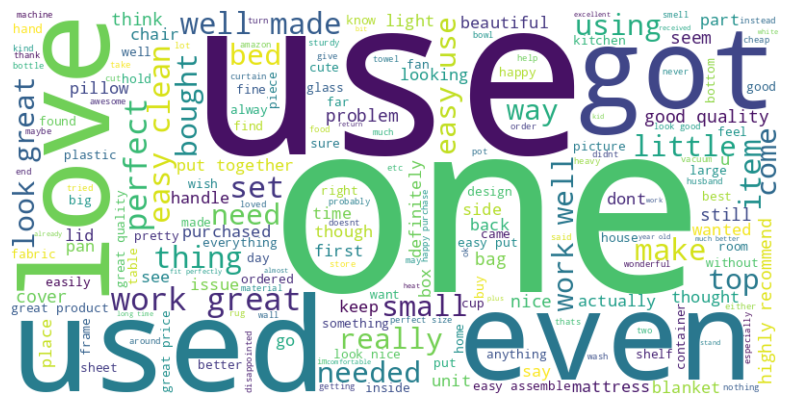

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = " ".join(df_filtered['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
df_filtered['verified_purchase'].value_counts()

verified_purchase
True     247327
False     18498
Name: count, dtype: int64

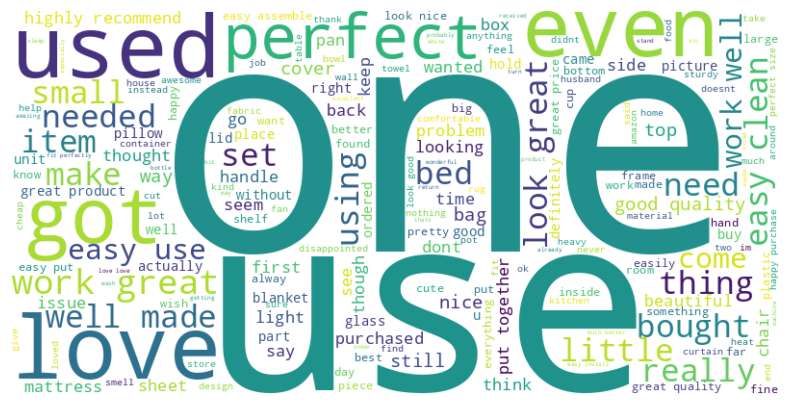

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

purchased_df = df_filtered[df_filtered['verified_purchase'] == True].copy()

text = " ".join(purchased_df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

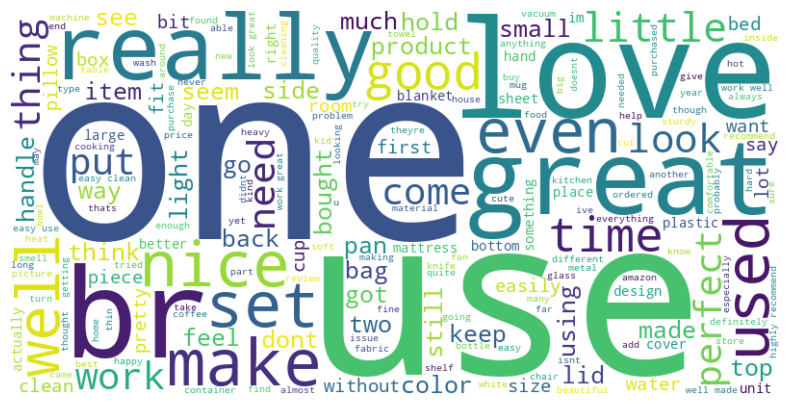

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

not_purchased_df = df_filtered[df_filtered['verified_purchase'] == False].copy()

text = " ".join(not_purchased_df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Text score distributions

/var/tmp/ipykernel_21592/3833686783.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sentiment'] = df_filtered['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


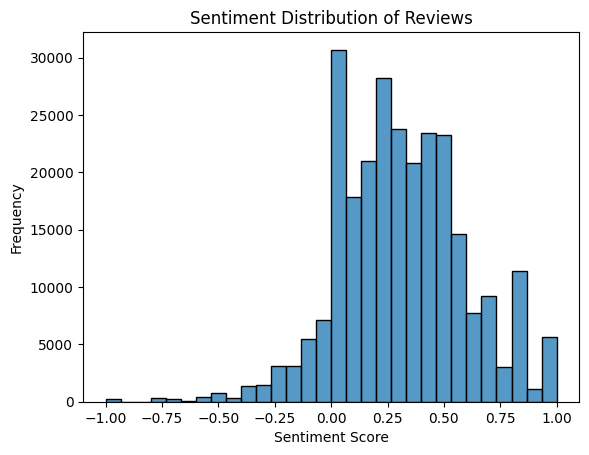

In [33]:
from textblob import TextBlob

# Calculate sentiment polarity
df_filtered['sentiment'] = df_filtered['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
sns.histplot(df_filtered['sentiment'], bins=30)
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.show()


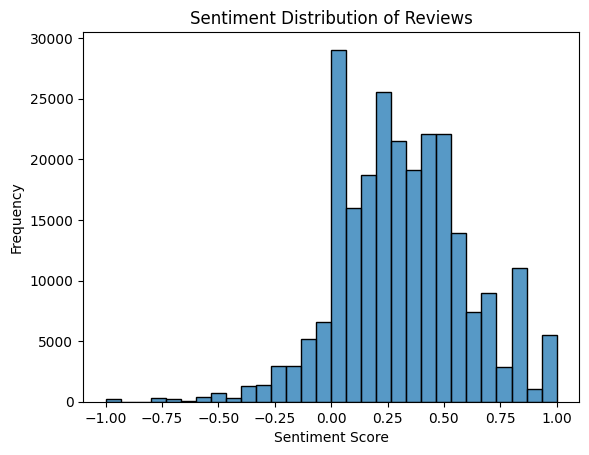

In [17]:
from textblob import TextBlob
import seaborn as sns

purchased_df = df_filtered[df_filtered['verified_purchase'] == True].copy()

# Calculate sentiment polarity
purchased_df['sentiment'] = purchased_df['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
sns.histplot(purchased_df['sentiment'], bins=30)
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

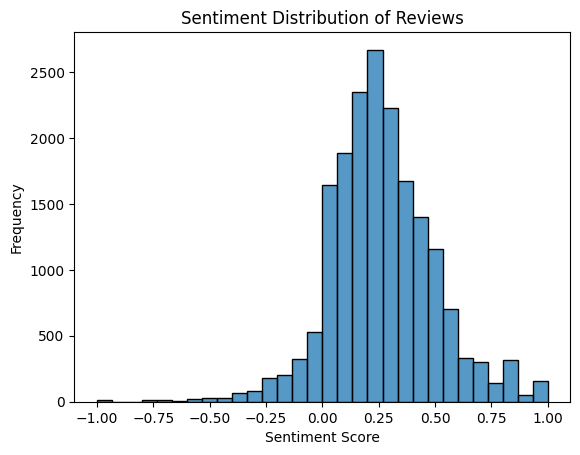

In [18]:
from textblob import TextBlob
import seaborn as sns

not_purchased_df = df_filtered[df_filtered['verified_purchase'] == False].copy()

# Calculate sentiment polarity
not_purchased_df['sentiment'] = not_purchased_df['processed_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
sns.histplot(not_purchased_df['sentiment'], bins=30)
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

/var/tmp/ipykernel_81956/2275753598.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['subjectivity'] = df_filtered['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)


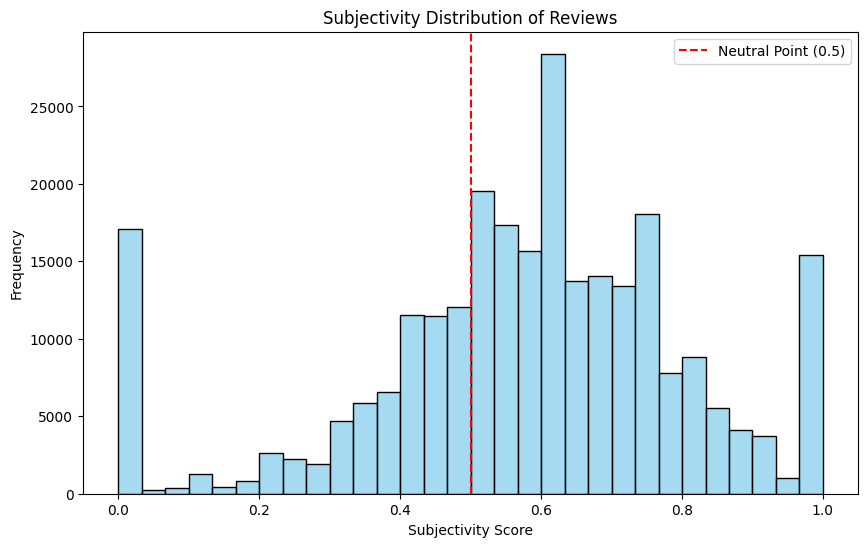

In [19]:
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_filtered['subjectivity'] = df_filtered['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['subjectivity'], bins=30, color='skyblue')
plt.title('Subjectivity Distribution of Reviews')
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Neutral Point (0.5)')  # Optional line for reference
plt.legend()
plt.show()


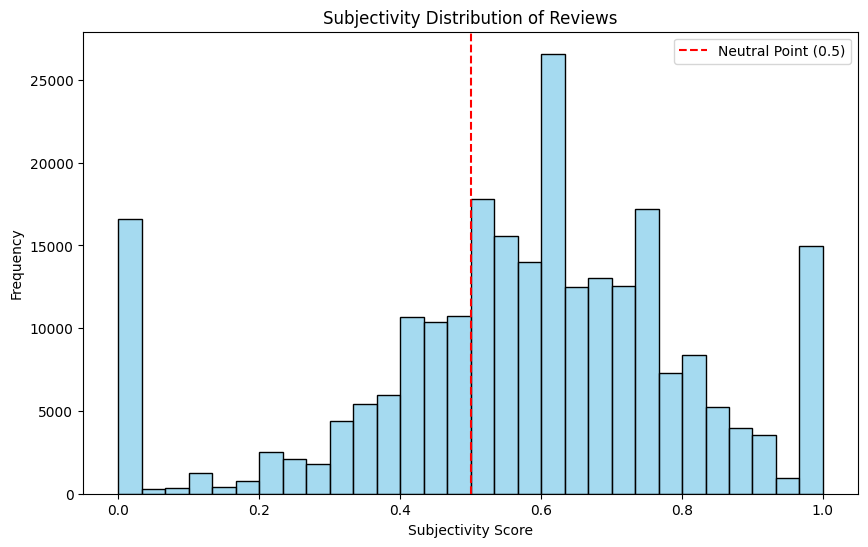

In [20]:
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

purchased_df = df_filtered[df_filtered['verified_purchase'] == True].copy()

purchased_df['subjectivity'] = purchased_df['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10, 6))
sns.histplot(purchased_df['subjectivity'], bins=30, color='skyblue')
plt.title('Subjectivity Distribution of Reviews')
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Neutral Point (0.5)')  # Optional line for reference
plt.legend()
plt.show()

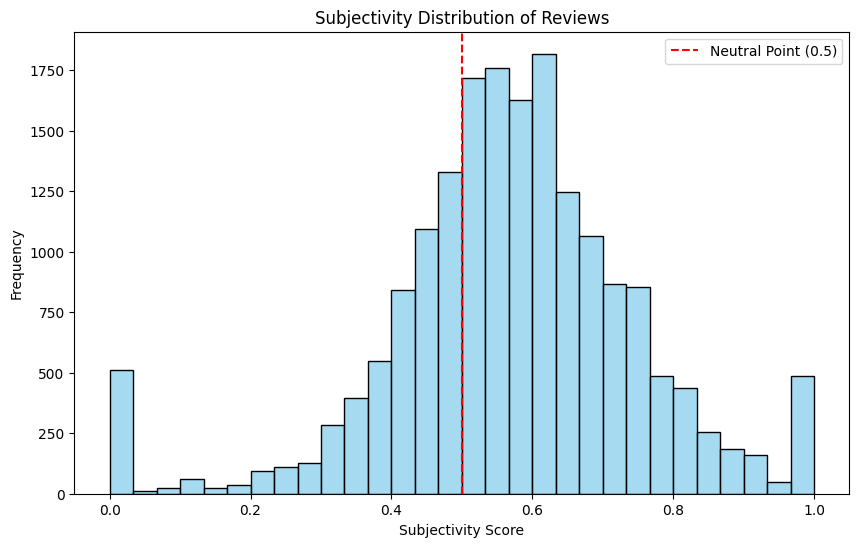

In [22]:
from textblob import TextBlob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

not_purchased_df = df_filtered[df_filtered['verified_purchase'] == False].copy()

not_purchased_df['subjectivity'] = not_purchased_df['processed_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(10, 6))
sns.histplot(not_purchased_df['subjectivity'], bins=30, color='skyblue')
plt.title('Subjectivity Distribution of Reviews')
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='Neutral Point (0.5)')  # Optional line for reference
plt.legend()
plt.show()

### Review Length

/var/tmp/ipykernel_21592/3121204300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['review_length'] = df_filtered['processed_text'].apply(len)


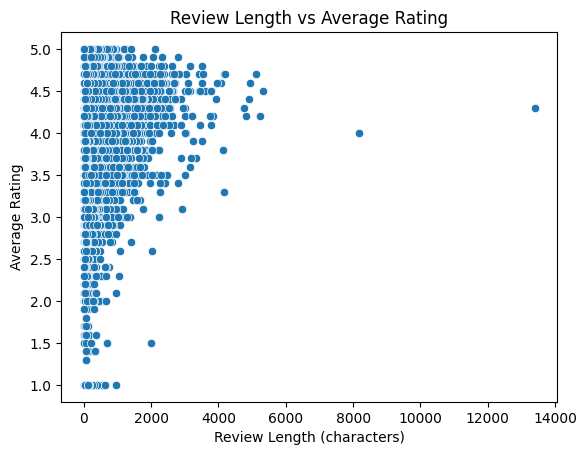

In [37]:
df_filtered['review_length'] = df_filtered['processed_text'].apply(len)
sns.scatterplot(data=df_filtered, x='review_length', y='average_rating_x')
plt.title('Review Length vs Average Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Average Rating')
plt.show()


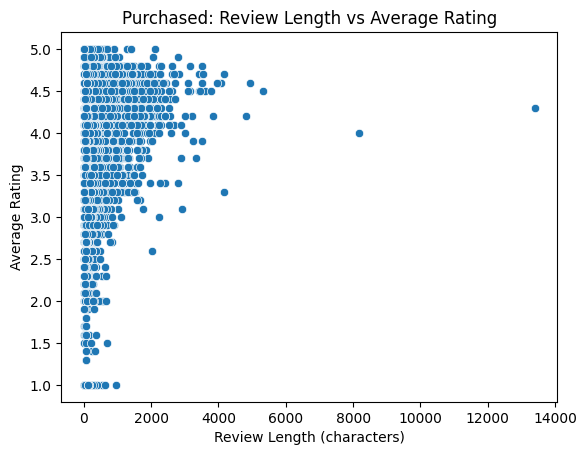

In [24]:
purchased_df = df_filtered[df_filtered['verified_purchase'] == True].copy()

purchased_df['review_length'] = purchased_df['processed_text'].apply(len)
sns.scatterplot(data=purchased_df, x='review_length', y='average_rating_x')
plt.title('Purchased: Review Length vs Average Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Average Rating')
plt.show()

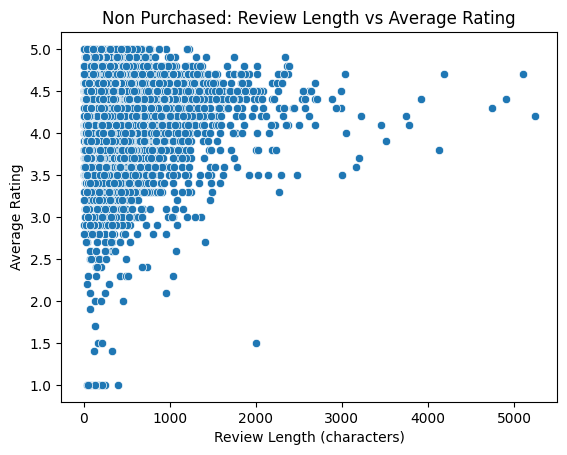

In [23]:
not_purchased_df = df_filtered[df_filtered['verified_purchase'] == False].copy()

not_purchased_df['review_length'] = not_purchased_df['processed_text'].apply(len)
sns.scatterplot(data=not_purchased_df, x='review_length', y='average_rating_x')
plt.title('Non Purchased: Review Length vs Average Rating')
plt.xlabel('Review Length (characters)')
plt.ylabel('Average Rating')
plt.show()

In [16]:
!pip install seaborn

### Standard EDA

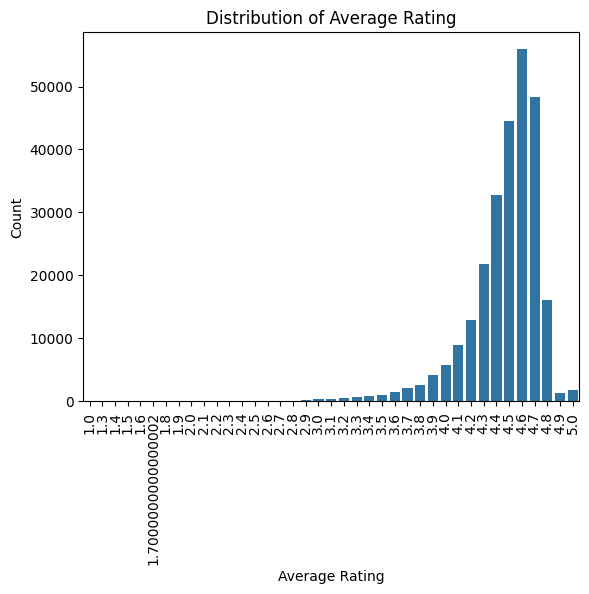

In [26]:
import seaborn as sns

sns.countplot(data=df_filtered, x='average_rating_x')
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Count')

plt.xticks(rotation=90)  # Rotate ticks by 45 degrees
plt.show()

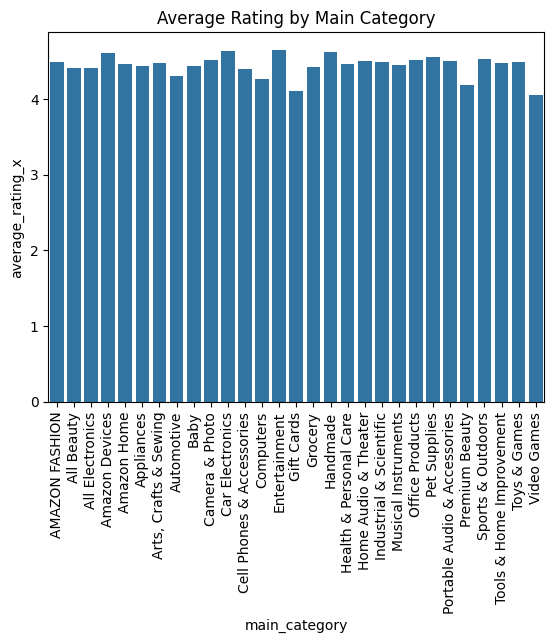

In [32]:
#temp = df_filtered['main_category'].value_counts()[:10]

avg_rating_by_category = df_filtered.groupby('main_category')['average_rating_x'].mean().reset_index()
sns.barplot(data=avg_rating_by_category, x='main_category', y='average_rating_x')
plt.xticks(rotation=90)
plt.title('Average Rating by Main Category')
plt.show()


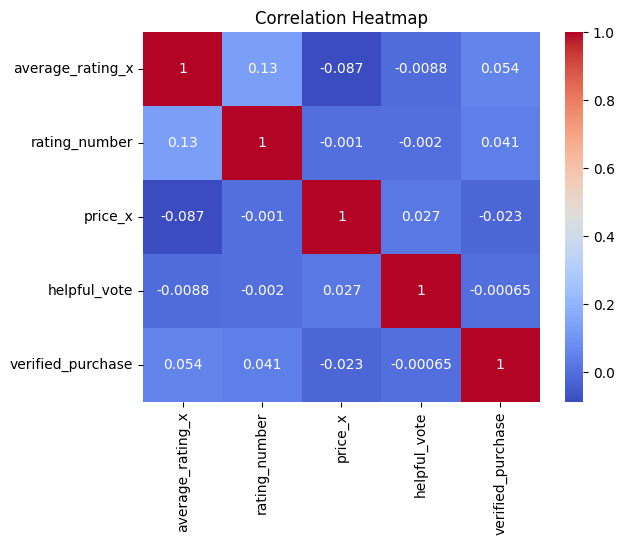

In [35]:
correlation_matrix = df_filtered[['average_rating_x', 'rating_number', 'price_x', 'helpful_vote', 'verified_purchase']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
